# COSE474-2024F: Deep Learning HW2

2021100019 / 컴퓨터학과 / 양은서

## 7.1. From Fully Connected Layers to Convolutions

All in Discussions Part!

## 7.2. Convolutions for Images

In [1]:
!pip install d2l==1.0.3

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

### 7.2.1. The Cross-Correlation Operation

- kernel window(= convolution window): height and width of the kernel
- window 별로 dot product(= cross-correlation operation) 진행

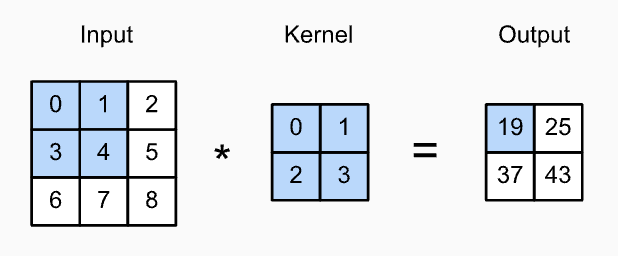

In [3]:
def corr2d(X, K):
    """Compute 2D cross-correlation."""
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y

In [4]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

### 7.2.2. Convolution Layers

In [5]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

### 7.2.3. Object Edge Detection in Images

In [6]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [7]:
K = torch.tensor([[1.0, -1.0]])

In [8]:
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

In [9]:
corr2d(X.t(), K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

### 7.2.4. Learning a Kernel

In [10]:
conv2d = nn.LazyConv2d(1, kernel_size=(1, 2), bias=False)

X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if (i+1) % 2 == 0:
        print(f'epoch {i+1}, loss {l.sum():.3f}')

epoch 2, loss 7.919
epoch 4, loss 1.357
epoch 6, loss 0.239
epoch 8, loss 0.045
epoch 10, loss 0.009


In [11]:
conv2d.weight.data.reshape((1, 2))

tensor([[ 0.9914, -0.9795]])

### 7.2.5. Cross-Correlation and Convolution

- In order to obtain the output of the strict convolution operation, we only need to flip the two-dimensional kernel tensor both horizontally and vertically, and then perform the cross-correlation operation with the input tensor.

### 7.2.6. Feature Map and Receptive Field

convolution layer output = feature map
- learned representations in the spatial dimensions

receptive field = affect the calculation of $x$ during the forward propagation.

## 7.3. Padding and Stride

In [12]:
import torch
from torch import nn

### 7.3.1. Padding

issue: tend to lose pixels on the perimeter of our image.
- when use small kernels -> only lose a few pixels but this can add up as we apply many successive convolutional layers.

solution: to add extra pixels of filler around the boundary

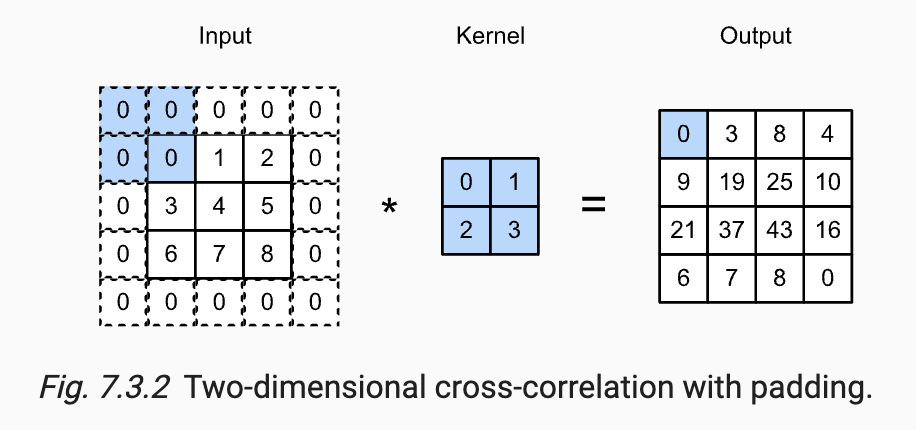

In [13]:
def comp_conv2d(conv2d, X):
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)
    return Y.reshape(Y.shape[2:])

conv2d = nn.LazyConv2d(1, kernel_size=3, padding=1)
X = torch.rand(size=(8, 8))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

In [14]:
conv2d = nn.LazyConv2d(1, kernel_size=(5, 3), padding=(2, 1))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

### 7.3.2. Stride

sliding as **stride**: move our window more than one element at a time, skipping the intermediate locations.

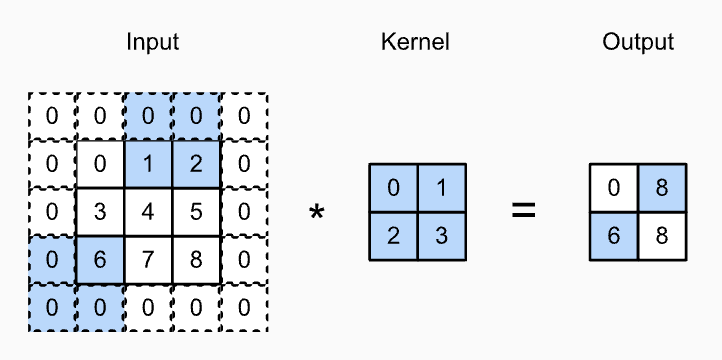

In [15]:
conv2d = nn.LazyConv2d(1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

torch.Size([2, 2])

## 7.4. Multiple Input and Multiple Output Channels

In [16]:
import torch
from d2l import torch as d2l

### 7.4.1. Mutiple Input Channels

- need to construct a convolution kernel with the same number of input channels.

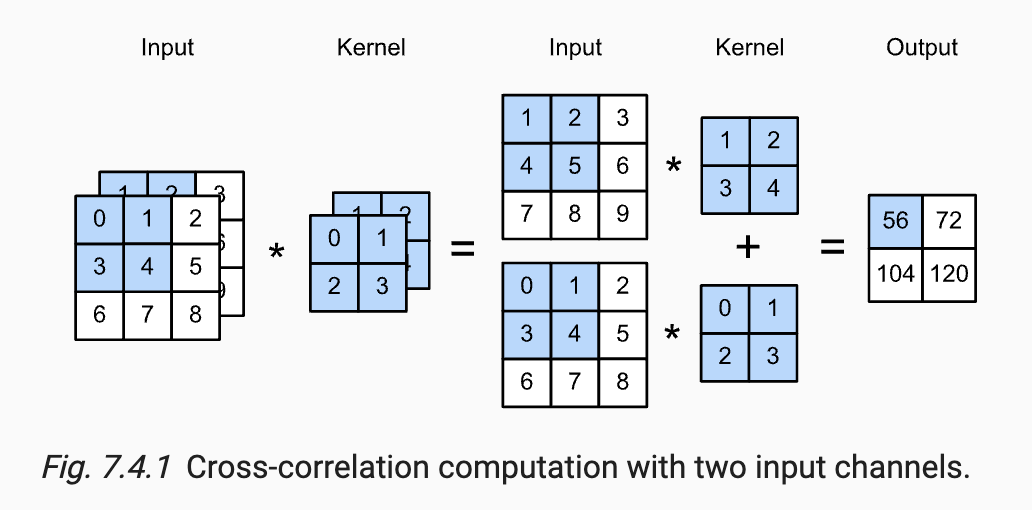

In [17]:
def corr2d_multi_in(X, K):
    return sum(d2l.corr2d(x, k) for x, k in zip(X, K))

In [18]:
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
                 [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

### 7.4.2. Multiple Output Channels

In [19]:
def corr2d_multi_in_out(X, K):
    return torch.stack([corr2d_multi_in(X, k) for k in K], 0)

In [20]:
K = torch.stack((K, K+1, K+2), 0)
K.shape

torch.Size([3, 2, 2, 2])

In [21]:
corr2d_multi_in_out(X, K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

### 7.4.3. 1 $\times$ 1 Convolutional Layer

- the minimum window -> lose the ability of larger convolution layers to recognize patterns consisting of interactions among adjacent elements

In [22]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h*w))
    K = K.reshape((c_o, c_i))
    Y = torch.matmul(K, X)
    return Y.reshape((c_o, h, w))

In [23]:
X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))
Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)
assert float(torch.abs(Y1 - Y2).sum()) < 1e-6

## 7.5. Pooling

In [24]:
import torch
from torch import nn
from d2l import torch as d2l

### 7.5.1. Maximum Pooling and Average Pooling

In [25]:
def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i:i+p_h, j:j+p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i:i+p_h, j:j+p_w].mean()
    return Y

In [26]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2))

tensor([[4., 5.],
        [7., 8.]])

In [27]:
pool2d(X, (2, 2), 'avg')

tensor([[2., 3.],
        [5., 6.]])

### 7.5.2. Padding and Stride

In [28]:
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

In [29]:
pool2d = nn.MaxPool2d(3)
pool2d(X)

tensor([[[[10.]]]])

In [30]:
pool2d = nn.MaxPool2d((2, 3), stride=(2, 3), padding=(0, 1))
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

### 7.5.3. Multiiple Channels

In [31]:
X = torch.cat((X, X+1), 1)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

In [32]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

## 7.6. Convolutional Neural Networks (LeNet)

- LeNet: first published CNNs

In [33]:
import torch
from torch import nn
from d2l import torch as d2l

### 7.6.1. LeNet

(i) a convolutional encoder consisting of two convolutional layers

(ii) a dense block consisting of three fully connected layers

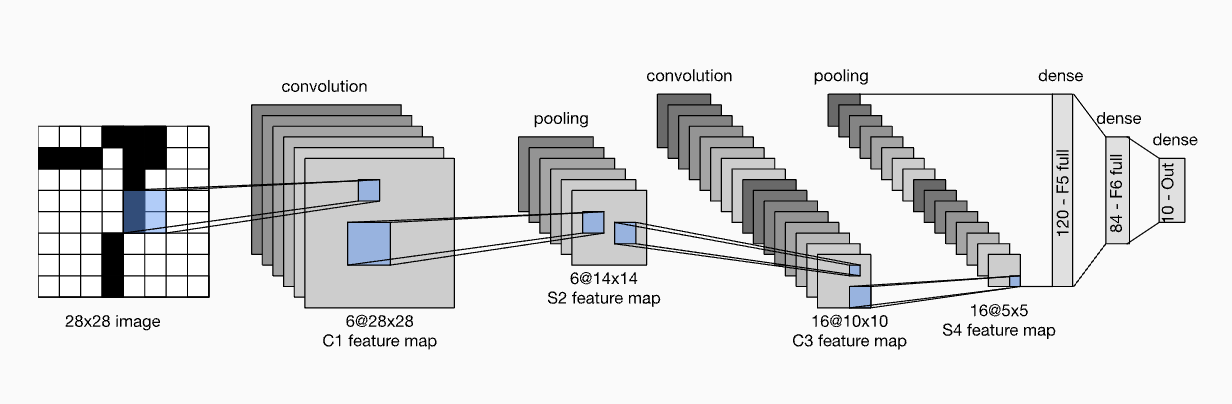

In [34]:
def init_cnn(module):
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

class LeNet(d2l.Classifier):
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(num_classes))

In [35]:
@d2l.add_to_class(d2l.Classifier)
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

model = LeNet()
model.layer_summary((1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


### 7.6.2. Training

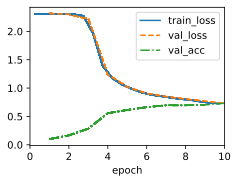

In [36]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = LeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

## 8.2. Networks Using Blocks (VGG)

In [37]:
import torch
from torch import nn
from d2l import torch as d2l

### 8.2.1. VGG Blocks

In [38]:
def vgg_block(num_convs, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.LazyConv2d(out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)

### 8.2.2. VGG Network

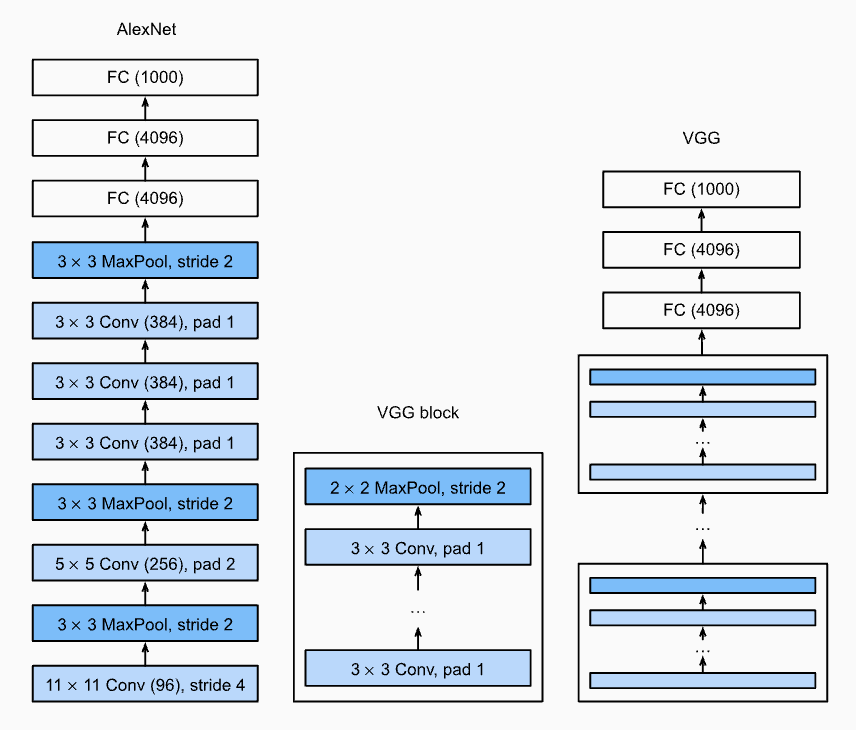

In [39]:
class VGG(d2l.Classifier):
    def __init__(self, arch, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        conv_blks = []
        for (num_convs, out_channels) in arch:
            conv_blks.append(vgg_block(num_convs, out_channels))
        self.net = nn.Sequential(
            *conv_blks, nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)

In [40]:
VGG(arch=((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))).layer_summary((1, 1, 224, 224))

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


### 8.2.3. Training

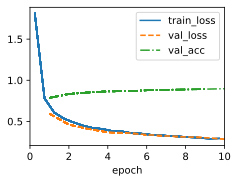

In [41]:
model = VGG(arch=((1, 16), (1, 32), (2, 64), (2, 128), (2, 128)), lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

## 8.6. Residual Networks (ResNet) and ResNeXt

In [42]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

### 8.6.1. Function Classes

$$f_{{F}}^* \stackrel{\text{def}}{=} \underset{f}{\text{argmin}} L(\mathbf{X}, \mathbf{y}, f) \text{ subject to } f \in {F}.$$

### 8.6.2. Residual Blocks

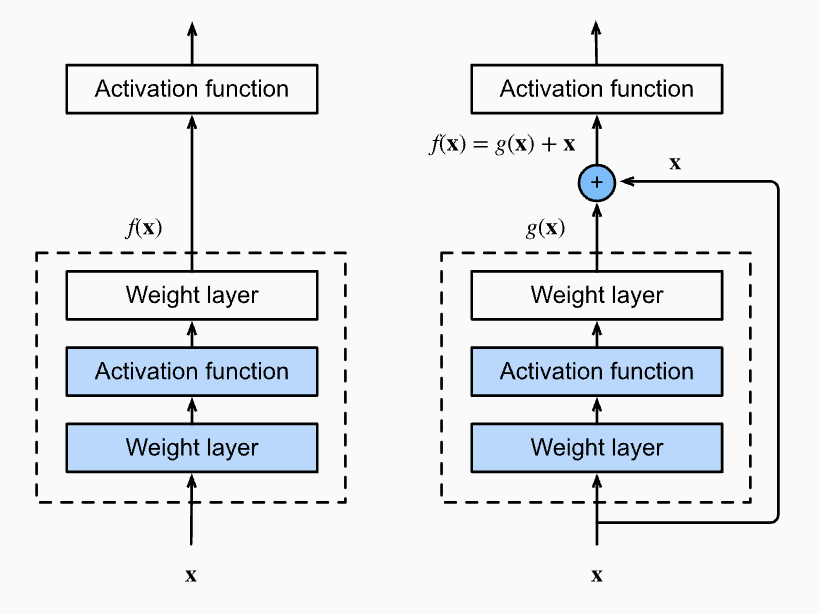

In [43]:
class Residual(nn.Module):
    """The Residual block of ResNet models."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

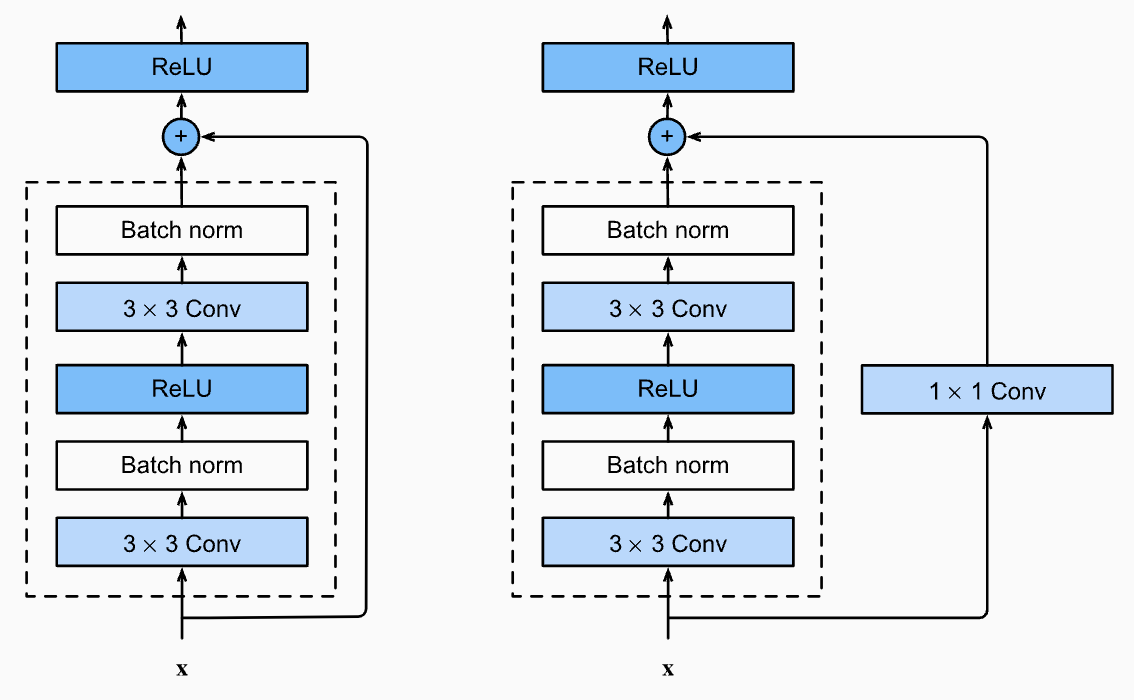

In [44]:
blk = Residual(3)
X = torch.randn(4, 3, 6, 6)
blk(X).shape

torch.Size([4, 3, 6, 6])

In [45]:
blk = Residual(6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

### 8.6.3. ResNet Model

In [46]:
class ResNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [47]:
@d2l.add_to_class(ResNet)
def block(self, num_residuals, num_channels, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels))
    return nn.Sequential(*blk)

In [48]:
@d2l.add_to_class(ResNet)
def __init__(self, arch, lr=0.1, num_classes=10):
    super(ResNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())
    for i, b in enumerate(arch):
        self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
    self.net.add_module('last', nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)

In [49]:
class ResNet18(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)),
                         lr, num_classes)

ResNet18().layer_summary((1, 1, 96, 96))

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 128, 12, 12])
Sequential output shape:	 torch.Size([1, 256, 6, 6])
Sequential output shape:	 torch.Size([1, 512, 3, 3])
Sequential output shape:	 torch.Size([1, 10])


### 8.6.4. Training

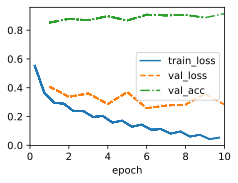

In [50]:
model = ResNet18(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

### 8.6.5. ResNeXt

ResNet has trade-off between nonlinearity & dimensionality within a given block.

-> to increase the number of channels that can carry information between blocks

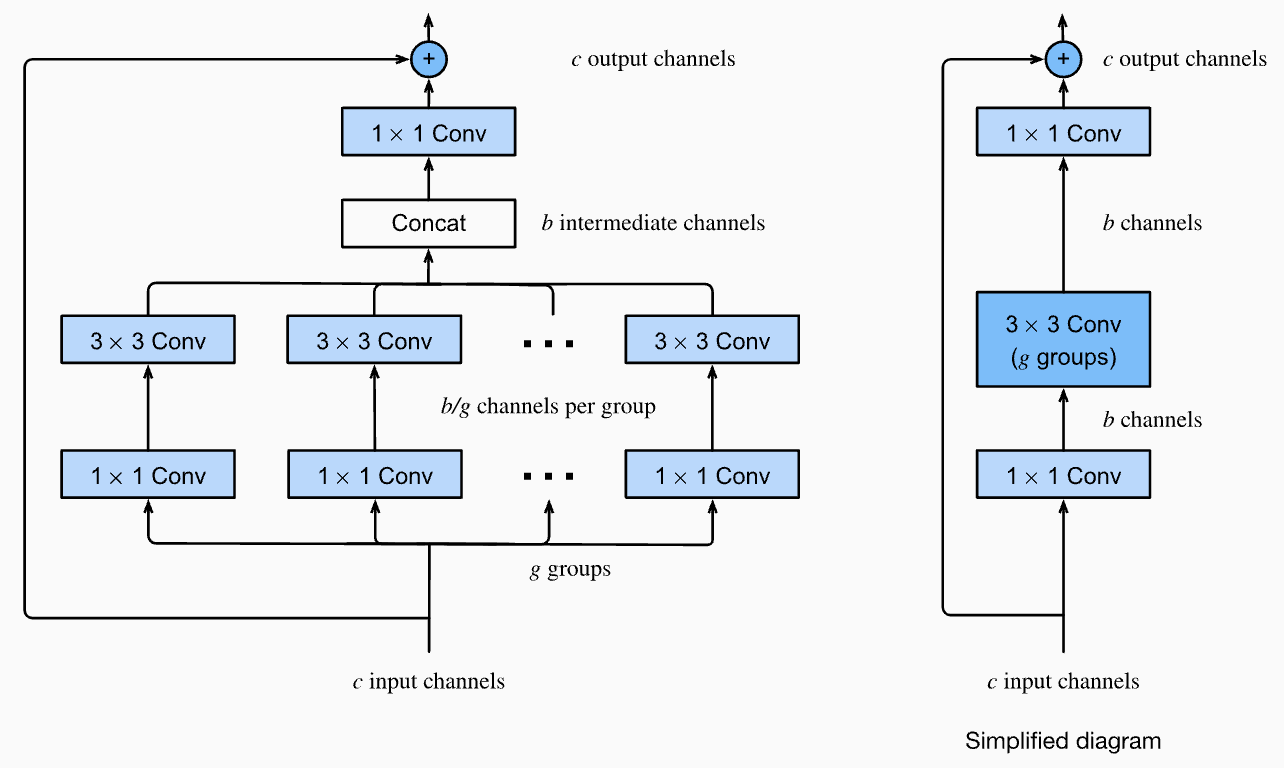

In [51]:
class ResNeXtBlock(nn.Module):
    """The ResNeXt block."""
    def __init__(self, num_channels, groups, bot_mul, use_1x1conv=False, strides=1):
        super().__init__()
        bot_channels = int(round(num_channels * bot_mul))
        self.conv1 = nn.LazyConv2d(bot_channels, kernel_size=1, stride=1)
        self.conv2 = nn.LazyConv2d(bot_channels, kernel_size=3, stride=strides, padding=1,
                                   groups=bot_channels//groups)
        self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1, stride=1)
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()
        self.bn3 = nn.LazyBatchNorm2d()
        if use_1x1conv:
            self.conv4 = nn.LazyConv2d(num_channels, kernel_size=1, stride=strides)
            self.bn4 = nn.LazyBatchNorm2d()
        else:
            self.conv4 = None

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = F.relu(self.bn2(self.conv2(Y)))
        Y = self.bn3(self.conv3(Y))
        if self.conv4:
            X = self.bn4(self.conv4(X))
        return F.relu(Y + X)

In [52]:
blk = ResNeXtBlock(32, 16, 1)
X = torch.randn(4, 32, 96, 96)
blk(X).shape

torch.Size([4, 32, 96, 96])

# Discussions & Exercises

### 7.1.1. Memo
1. In the earliest layers, our network should respond similarly to the same patch, regardless of where it appears in the image. This principle is called **translation invariance** (or translation equivariance).

2. The earliest layers of the network should focus on local regions, without regard for the contents of the image in distant regions. This is the **locality** principle. Eventually, these local representations can be aggregated to make predictions at the whole image level.

3. Deeper layers should be able to capture longer-range features of the image, in a way similar to higher level vision in nature.

#### 7.1.2.1. Translation Invariance

convolution

$$ [H]_{i, j} = u + Σ_a Σ_b [V]_{a, b}[X]_{i+a, j+b}. $$

#### 7.1.2.2. Locality

$ V $: convolution kernel, a filter, or simply the layer’s weights (hyperparameters)

$$ [H]_{i, j} = u + Σ_{a=-Δ}^{Δ} Σ_{b=-Δ}^{Δ} [V]_{a, b}[X]_{i+a, j+b}. $$

### 7.1.3. Convolutions

$$ (f*g)(x) = ∫f(z)g(x-z) dz. $$ \\
$$ (f*g)(i) = Σ_a(a)g(i-a) $$ \\
$$ (f*g)(i, j) = Σ_aΣ_bf(a, b) g(i-a, j-b) $$

### 7.1.4. Channels Memo

- rather than just having a single hidden representation corresponding to each spatial location, we want **an entire vector of hidden representations **corresponding to each spatial location.
- hidden representations as comprising a number of two-dimensional grids stacked on top of each other.
- **= feature maps = channels**

### 7.1.5. Summary and Discussion

The structure of CNN
- translation invariance = all patches of an image will be treated in the same manner.
- locality = only a small neighborhood of pixels will be used to compute the corresponding hidden representations.

How to reduce the number of parameters in a function class without limiting its expressive power.
- adding channels = bring back some of the complexity

### 7.2.7. Summary

The core computation: cross-correlation operation
- matrix-matrix operation between channels
- highly ***local***

Purposes of convolution
- detect edges and lines, blurring images, sharpening them

### 7.3.3. Summary

Padding can increase the height and width of the output.
- typically pick symmetric padding on both sides of the input height and width.

A similar convention applies to strides.
- The stride can reduce the resolution of the output
- it allows CNNs to encode implicit position information within an image, simply by learning where the “whitespace” is.

### 7.4.4. Discussion

- convolutions : allow for localized analysis of features

a practical trade-off between the drastic parameter reduction arising from translation invariance and locality, and the need for expressive and diverse models in computer vision.

### 7.5.1. Memo

pooling operators: fixed-shape window that is slid over all regions in the input
- contains no parameters
- deterministic: calculate maximum or the average value of the elements in the pooling window. => **maximum pooling/average pooling**

### 7.5.4. Summary

Pooling
- All convolution semantics apply in the same way
- indifferent to channels -> leave the number of channels unchanged and applies to each channel separately.
- max pooling / average pooling

### 7.6.3. Summary

LeNet-5
- incredible productivity boost that has democratized deep learning model development tremendously

### 8.2.1. Memo

Key Idea: use multiple convolutions in between downsampling via max-pooling in the form of a block

Back to VGG: a VGG block consists of a sequence of convolutions with $3 \times 3$
 kernels with padding of 1 (keeping height and width) followed by a $2 \times 2$
 max-pooling layer with stride of 2 (halving height and width after each block).

### 8.2.4. Summary

VGG: the first truly modern CNN that introduced key properties such as blocks of multiple convolutions and a preference for deep and narrow networks

### 8.6.6. Summary

- **Residual connections**: allow us to obtain strictly more powerful rather than also subtly different function classes when adding capacity by letting additional layers to simply pass through the input to the output.

- Residual connections had a major influence on the design of subsequent deep neural networks, of either convolutional or sequential nature.

- **ResNeXt**: the design of convolutional neural networks has evolved over time: by being more frugal with computation and trading it off against the size of the activations